<a href="https://colab.research.google.com/github/erichsdb/Neurocomputing/blob/main/notebooks/13-RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Recurrent neural networks

The goal is to learn to use LSTM layers in keras for sentiment analysis and time series prediction. The code for sentiment analysis is adapted from <https://victorzhou.com/blog/intro-to-rnns/>. The code for time series prediction is adapted from <https://www.tensorflow.org/tutorials/structured_data/time_series>.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

## Sentiment analysis

The goal to use recurrent neural networks (LSTM) to perform **sentiment analysis** on short sentences, i.e. to predict whether the sentence has a positive or negative meaning.

The following cells represent your training and test data. They are lists of lists, where the first element is the sentence as a string, and the second a boolean, with `True` for positive sentences, `False` for negative ones.

Notice how some sentences are ambiguous (if you do not notice the "not", the sentiment might be very different).

In [2]:
train_data = [
  ['good', True],
  ['bad', False],
  ['happy', True],
  ['sad', False],
  ['not good', False],
  ['not bad', True],
  ['not happy', False],
  ['not sad', True],
  ['very good', True],
  ['very bad', False],
  ['very happy', True],
  ['very sad', False],
  ['i am happy', True],
  ['this is good', True],
  ['i am bad', False],
  ['this is bad', False],
  ['i am sad', False],
  ['this is sad', False],
  ['i am not happy', False],
  ['this is not good', False],
  ['i am not bad', True],
  ['this is not sad', True],
  ['i am very happy', True],
  ['this is very good', True],
  ['i am very bad', False],
  ['this is very sad', False],
  ['this is very happy', True],
  ['i am good not bad', True],
  ['this is good not bad', True],
  ['i am bad not good', False],
  ['i am good and happy', True],
  ['this is not good and not happy', False],
  ['i am not at all good', False],
  ['i am not at all bad', True],
  ['i am not at all happy', False],
  ['this is not at all sad', True],
  ['this is not at all happy', False],
  ['i am good right now', True],
  ['i am bad right now', False],
  ['this is bad right now', False],
  ['i am sad right now', False],
  ['i was good earlier', True],
  ['i was happy earlier', True],
  ['i was bad earlier', False],
  ['i was sad earlier', False],
  ['i am very bad right now', False],
  ['this is very good right now', True],
  ['this is very sad right now', False],
  ['this was bad earlier', False],
  ['this was very good earlier', True],
  ['this was very bad earlier', False],
  ['this was very happy earlier', True],
  ['this was very sad earlier', False],
  ['i was good and not bad earlier', True],
  ['i was not good and not happy earlier', False],
  ['i am not at all bad or sad right now', True],
  ['i am not at all good or happy right now', False],
  ['this was not happy and not good earlier', False],
]

In [3]:
test_data = [
  ['this is happy', True],
  ['i am good', True],
  ['this is not happy', False],
  ['i am not good', False],
  ['this is not bad', True],
  ['i am not sad', True],
  ['i am very good', True],
  ['this is very bad', False],
  ['i am very sad', False],
  ['this is bad not good', False],
  ['this is good and happy', True],
  ['i am not good and not happy', False],
  ['i am not at all sad', True],
  ['this is not at all good', False],
  ['this is not at all bad', True],
  ['this is good right now', True],
  ['this is sad right now', False],
  ['this is very bad right now', False],
  ['this was good earlier', True],
  ['i was not happy and not good earlier', False],
  ['earlier i was good and not bad', True],
]

In [4]:
N_train = len(train_data)
N_test = len(test_data)
print(N_train, "training sentences.")
print(N_test, "test sentences.")

58 training sentences.
21 test sentences.


### Data preparation

The most boring part when training LSTMs on text is to prepare the data correctly. Sentences are sequences of words (possibly a huge number of words), with a variable length (some sentences are shorter than others).

What neural networks expect as input is a fixed-length sequence of numerical vectors $\{\mathbf{x}_t\}_{t=0}^T$, i.e. they must have a fixed size. So we need to transform each sentence into this format.

The first thing to do is to identify the vocabulary, i.e. the **unique** words in the training set (fortunately, the test set uses the same exact words) as well as the maximal number of words in each sentence (again, the test set does not have longer sentences).

**Q:** Create a list `vocabulary` of unique words in the training set and compute the maximal length `nb_words` of a sentence.

To extract the words in each sentence, the `split()` method of Python strings might come handy:

```python
sentence = "I fear this exercise will be difficult"
print(sentence.split(" "))
```

You will also find the `set` Python object useful to identify unique works. Check the doc. But there are many ways to do that (for loops), just do it the way you prefer.

In [23]:
vocabulary = set()

for i in train_data:
  vocabulary.update(i[0].split(" "))

print(vocabulary)
print(len(vocabulary))

{'sad', 'all', 'and', 'happy', 'good', 'earlier', 'bad', 'am', 'or', 'not', 'was', 'at', 'i', 'right', 'is', 'now', 'very', 'this'}
18



Now that we have found our list of 18 unique words, we need to able to perform **one-hot encoding** of each word, i.e. write a method `def one_hot_encoding(word, vocabulary)` that takes a word (e.g. "good") and the vocabulary, and returns a vector of size 18, with mostly zeros, except for a `1.0` at the location of the word in the vocabulary.

For example, if your vocabulary is `["I", "love", "you"]`, the one-hot encoding of "I" should be `np.array([1., 0., 0.])`, the one of "love" is `np.array([0., 1., 0.])`, etc.

**Q:** Implement the `one_hot_encoding()` method for single words.

*Hint:* you might find the method `index()` of list objects interesting.

In [24]:
def one_hot_encoding(word, vocabulary):
  one_hot = np.zeros(len(vocabulary))
  one_hot[vocabulary.index(word)] = 1
  return one_hot

one_hot_encoding("good", list(vocabulary))

array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.])

**Q:** You can now create the training set `X_train, T_train` and the test set `X_test, T_test`.

The training input data `X_train` should be a numpy array with 3 dimensions:

```python
 X_train = np.zeros((N_train, nb_words, len(vocabulary)))
```

The first index corresponds to each sentence. The second index represents the index of each word in the sentence (maximally `nb_words=10`). The third index is for the one-hot encoding (18 elements).

**Beware:** most sentences are shorter than `nb_words=10`. In that case, the words should be set **at the end of the sequence**, i.e. you prepend zero vectors.

For example, "I love you" should be encoded as:

```python
"", "", "", "", "", "", "", "I", "love", "you"
```

not as:

```python
"I", "love", "you", "", "", "", "", "", "", ""
```

The reason for that is that the LSTM will get the words one by one and only respond "positive" or "negative" after the last word has been seen. If the words are provided at the beginning of the sequence, vanishing gradients might delete them.

The same holds for the test set, it only has less sentences.

In [41]:
from pprint import pprint

nb_words = 10

X_train = np.zeros((N_train, nb_words, len(vocabulary)))

### TRAIN ###

# index of each senctence
for sentence in train_data:
  index = train_data.index(sentence)
  # index of each word in each sentence
  words_in_sentence = sentence[0].split(" ")
  for word in words_in_sentence:
    word_index = words_in_sentence.index(word)
    X_train[index][word_index] = (one_hot_encoding(word, list(vocabulary)))

pprint(X_train[0][0])

T_train = np.array([x[1] for x in train_data])

### TEST ###

X_test = np.zeros((N_test, nb_words, len(vocabulary)))

for sentence in test_data:
  index = test_data.index(sentence)
  # index of each word in each sentence
  words_in_sentence = sentence[0].split(" ")
  for word in words_in_sentence:
    word_index = words_in_sentence.index(word)
    X_test[index][word_index] = (one_hot_encoding(word, list(vocabulary)))

pprint(X_test[0][0])

T_test = np.array([x[1] for x in test_data])


array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.])
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1.])


### Training the LSTM

Now we just have to provide the data to a recurrent network. The problem is not very complicated, so we will need a single LSTM layer, followed by a single output neuron (with the logistic transfer function) whose role is to output 1 for the positive class, 0 for the negative one.

**Q:** Check the documentation for the LSTM layer of `keras`: <https://keras.io/api/layers/recurrent_layers/lstm/>. It has many parameters:

```python
tf.keras.layers.LSTM(
    units,
    activation='tanh',
    recurrent_activation='sigmoid',
    use_bias=True,
    kernel_initializer='glorot_uniform',
    recurrent_initializer='orthogonal',
    bias_initializer='zeros',
    unit_forget_bias=True,
    kernel_regularizer=None,
    recurrent_regularizer=None, bias_regularizer=None,
    activity_regularizer=None, kernel_constraint=None,
    recurrent_constraint=None, bias_constraint=None,
    dropout=0.0, recurrent_dropout=0.0,
    implementation=2,
    return_sequences=False, return_state=False,
    go_backwards=False, stateful=False, unroll=False)
```

The default value for the parameters is the vanilla LSTM seen in the lectures, but you have the possibility to change the activation functions for the inputs and outputs (not the gates, it must be a sigmoid!), initialize the weights differently, add regularization or dropout, use biases or not, etc. That's a lot to play with. For this exercise, stick to the default parameters at the beginning. The only thing you need to define is the number of neurons `units` of the layer.

```python
tf.keras.layers.LSTM(units=N)
```

Note that an important parameter is `return_sequences`. When set to False (the default), the LSTM layer will process the complete sequence of 10 word vectors, and output a single vector of $N$ values (the number of units). When set to True, the layer would return a sequence of 10 vectors of size $N$.

Here, we only want the LSTM layer to encode the sentence and feed a single vector to the output layer, so we can leave it to False. If we wanted to stack two LSTM layers on top of each other, we would need to set `return_sequences` to True for the first layer and False for the second one (you can try that later):

```python
tf.keras.layers.LSTM(N, return_sequences=True)
tf.keras.layers.LSTM(M, return_sequences=False)
```

**Q:** Create a model with one LSTM layer (with enough units) and one output layer with one neuron (`'sigmoid'` activation function). Choose an optimizer (SGD, RMSprop, Adam, etc) and a good learning rate. When compiling the model, use the `'binary_crossentropy'` loss function as it is a binary classification.

The input layer of the network must take a `(nb_words, len(vocabulary))` matrix as input, i.e. (window, nb_features).

```python
tf.keras.layers.Input((nb_words, len(vocabulary)))
```

When training the model with `model.fit()`, you can pass the test set as validation data, as we do not have too many examples:

```python
model.fit(X_train, T_train, validation_data=(X_test, T_test), ...)
```

Train the model for enough epochs, using a batch size big enough but not too big. In other terms: do the hyperparameter search yourself ;).


In [44]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.LSTM(units=64, input_shape=(nb_words, len(vocabulary))))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

optimizer = tf.keras.optimizers.Adam()

model.compile(
    loss="binary_crossentropy",
    optimizer=optimizer,
    metrics=['accuracy'])

# History tracks the evolution of the metrics during learning
history = tf.keras.callbacks.History()

# Training procedure
model.fit(
    X_train, T_train, # training data
    batch_size=64,  # batch size
    epochs=100, # Maximum number of epochs
    validation_split=0.1, # Perceptage of training data used for validation
    callbacks=[history] # Track the metrics at the end of each epoch
)

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.5000 - loss: 0.6939 - val_accuracy: 0.3333 - val_loss: 0.6955
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.5192 - loss: 0.6931 - val_accuracy: 0.5000 - val_loss: 0.6953
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.5000 - loss: 0.6924 - val_accuracy: 0.6667 - val_loss: 0.6952
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.5385 - loss: 0.6916 - val_accuracy: 0.6667 - val_loss: 0.6952
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.5385 - loss: 0.6908 - val_accuracy: 0.6667 - val_loss: 0.6953
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.5385 - loss: 0.6901 - val_accuracy: 0.6667 - val_loss: 0.6954
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.5385 - loss: 0.6893 - val_accuracy: 0.6667 - val_loss: 0.6957
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.5385 - loss: 0.6885 - val_accuracy: 0.6667 - val_loss: 0.6959
Epoch

**Q.** Once you have been able to successfully train the network, vary the different parts of the model to understand their influence: learning rate, number of units, optimizer, etc. Add another LSTM layer to see what happens. Exchange the LSTM layer with the GRU layer.

## Time series prediction

Another useful function of RNNs is forecasting, i.e. predicting the rest of a sequence (financial markets, weather, etc.) based on its history.

Let's generate a dummy one-dimensional signal with 10000 points:


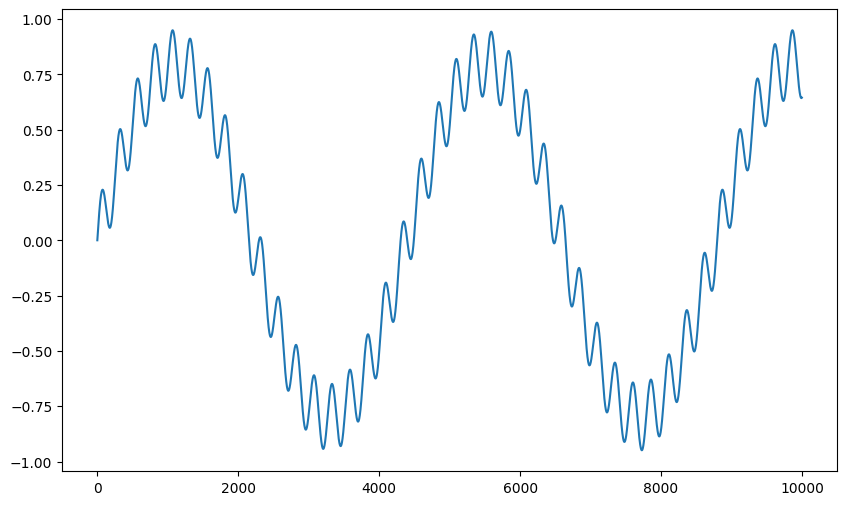

In [45]:
N = 10000
time_axis = np.arange(N)

signal = 0.8*np.sin(time_axis/700) + 0.15*np.sin(time_axis/40)

plt.figure(figsize=(10, 6))
plt.plot(signal)
plt.show()

We are going to use a small window (50 points) to feed the LSTM. The goal will be to perform **one-step ahead prediction**: given the last 50 points, what will be the next one?

The following cell prepares the data for the problem. Check that the data is what you expect.

In [ ]:
window = 50

X = np.array(
    [signal[t: t+ window] for t in time_axis[:-window]]
)

t = signal[time_axis[1:-window+1]]

print(X.shape)
print(t.shape)

We now split the signal into training and test sets. The training set consists of the 9000 first points, while the test set consists of the remaining 1000 points (the future). Note that the test set is not exactly contained in the training set as the function is not periodic, but quite.

In [ ]:
nb_train = 9000

X_train = X[:nb_train]
T_train = t[:nb_train]
X_test = X[nb_train:]
T_test = t[nb_train:]

**Q:** Create a neural network taking a `(window, 1)` input, with one LSTM layer and one output neuron using the tanh activation function (as the targets are between -1 and 1). Train it on the data as a regression problem (use many epochs). Track the mean average error (`metrics=['mae']`) in addition to the mse, as it indicates better the prediction error. After training, plot the prediction for the test set and compare it to the ground truth.

It seems possible to get a high precision on the test set, but there is a trick. The sequence fed as an input when testing consists of **real** measurements. The network has only learned to predict the next data point. Can we use that model to predict the next 1000 points without seeing the true data?

For that, we need to build an **auto-regressive model**, i.e. to feed inputs to the network consisting of predictions, not of real data points. We need a structure that can represent a fixed-size window of data points, where we can append predictions one by one. The following cell provides you with a simple implementation:

In [ ]:
from collections import deque

class Buffer:
    "Fixed size buffer allowing to append predictions."
    def __init__(self, window, data):
        self.window = window
        self.data  = data.reshape((1, window))

    def append(self, value):
        d = deque([x for x in list(self.data[0, :])])
        d.popleft()
        d.append(value)
        self.data = np.array(d).reshape((1, self.window))


You can create the buffer by intializing it with the first test sample consisting of 50 real data points:

```python
buffer = Buffer(window, X_test[0, :])
```

`buffer.data` can be passed directly to the model in order to make a prediction:

```python
y = model.predict(buffer.data)[0, 0]
```

This prediction can be appended to the buffer, which can be used as the next input to the model:

```python
buffer.append(y)
```

**Q:** Make recursive prediction using your trained model. Does it work?